In [21]:
import numpy as np
import scipy.special as sc_special
import tensorflow as tf 
from 	tensorflow import keras
import pandas as pd
from tensorflow.keras import optimizers,metrics,layers,Sequential


In [22]:
# 导入数据以及预处理
data = pd.read_csv('DATASETS/GY_AIR.csv',sep=',',header=0,usecols=[1,2,3,4,5,6,7])

data = data.sample(frac = 1) #打乱数据

X = data.iloc[:410,1:]
Y = data.iloc[:410,0]
TestX = data.iloc[410:,1:]
TestY = data.iloc[410:,0]

inputnum = 6
hiddennum = 10
outputnum = 3
numsum = inputnum*hiddennum+hiddennum+hiddennum*outputnum+outputnum #6*10+10+10*3+3=103
bestfit = []  #保存CS迭代过程中的loss、acc，画图用
bestloss = []
LossArr = []


n_train = X.shape[0]
#弱分类器数量
M = 5


def preprocess(x,y):
    x = tf.cast(x,dtype=tf.float32) #/ X.max().max()
    y = tf.cast(y,dtype=tf.int32)
    y = tf.one_hot(y,depth=3)
    return x,y
len(X),len(TestX)

(410, 40)

In [23]:
#数据预处理

#零均值处理
X.iloc[:,0] -= np.mean(X,axis=0)[0]  
X.iloc[:,1] -= np.mean(X,axis=0)[1]
X.iloc[:,2] -= np.mean(X,axis=0)[2]
X.iloc[:,3] -= np.mean(X,axis=0)[3]  
X.iloc[:,4] -= np.mean(X,axis=0)[4]
X.iloc[:,5] -= np.mean(X,axis=0)[5]
#归一化
X.iloc[:,0] /= np.max(np.abs(X),axis=0)[0]
X.iloc[:,1] /= np.max(np.abs(X),axis=0)[1]
X.iloc[:,2] /= np.max(np.abs(X),axis=0)[2]
X.iloc[:,3] /= np.max(np.abs(X),axis=0)[3]  
X.iloc[:,4] /= np.max(np.abs(X),axis=0)[4]
X.iloc[:,5] /= np.max(np.abs(X),axis=0)[5]
#零均值处理
TestX.iloc[:,0] -= np.mean(TestX,axis=0)[0]  
TestX.iloc[:,1] -= np.mean(TestX,axis=0)[1]
TestX.iloc[:,2] -= np.mean(TestX,axis=0)[2]
TestX.iloc[:,3] -= np.mean(TestX,axis=0)[3]  
TestX.iloc[:,4] -= np.mean(TestX,axis=0)[4]
TestX.iloc[:,5] -= np.mean(TestX,axis=0)[5]
#归一化
TestX.iloc[:,0] /= np.max(np.abs(TestX),axis=0)[0]
TestX.iloc[:,1] /= np.max(np.abs(TestX),axis=0)[1]
TestX.iloc[:,2] /= np.max(np.abs(TestX),axis=0)[2]
TestX.iloc[:,3] /= np.max(np.abs(TestX),axis=0)[3]  
TestX.iloc[:,4] /= np.max(np.abs(TestX),axis=0)[4]
TestX.iloc[:,5] /= np.max(np.abs(TestX),axis=0)[5]
batchsz = 16
db = tf.data.Dataset.from_tensor_slices((X,Y))
db = db.map(preprocess).batch(batchsz)#.shuffle(60000)
ds_val = tf.data.Dataset.from_tensor_slices((TestX,TestY))
ds_val = ds_val.map(preprocess).batch(batchsz)
sample = next(iter(db))
print(sample[0].shape,sample[1].shape)
Y_onehot = tf.one_hot(Y,depth=3)
TestY_onehot = tf.one_hot(TestY,depth=3)
X = tf.cast(X,dtype=tf.float32)# / 203.
TestX = tf.cast(TestX,dtype=tf.float32) #/ 203.

(16, 6) (16, 3)


In [24]:

#n：布谷鸟数  m：布谷鸟的维度
def cuckoo_search(n, m, lower_boundary, upper_boundary, iter_num = 20,pa = 0.25, beta = 1.5, step_size = 0.1):

    # get initial nests' locations 
    nests = generate_nests(n, m, lower_boundary, upper_boundary)
    fitness,lossness = calc_fitness( nests,0.5) #包含所有的适应度  用列表存储
    
    #得到每代最小loss
    best_loss_index = np.argmin(lossness)
    best_loss = lossness[best_loss_index]
    best_nestloss = nests[best_loss_index].copy()
    #bestloss.append(best_loss)
    
    # get the best nest and record it
    best_nest_index = np.argmax(fitness)
    best_fitness = fitness[best_nest_index]
    best_nest = nests[best_nest_index].copy()
    #bestfit.append(best_fitness) #全局变量，保存每代最佳适应度值
    
    best_two_nest = best_nest
    best_two_loss = best_fitness
    best_two_fitness = lossness[best_nest_index]
    print('\r\n BEST_TWO_LOSSNESS IS %.2f : \r\n',best_two_loss)
    print('\r\n BEST_TWO_FITNESS IS %.2f : \r\n',best_two_fitness)
    for _ in range(iter_num):
        nests = update_nests(lower_boundary, upper_boundary, nests, best_nest, fitness, step_size,best_fitness)
        nests = abandon_nests(nests, lower_boundary, upper_boundary, pa)
        print('\r\n*******************************************************一轮迭代后开始计算适应度*************************************************************\r\n')
        fitness,lossness = calc_fitness( nests,best_fitness)
        print('\r\n*****************************************************************结束************************************************************\r\n')
        max_nest_index = np.argmax(fitness)
        max_fitness = fitness[max_nest_index]
        max_nest = nests[max_nest_index]
        bestfit.append(max_fitness)
        
        min_loss_index = np.argmin(lossness)
        min_loss = lossness[min_loss_index]
        min_loss_fit = fitness[min_loss_index]
        min_nestloss = nests[min_loss_index]
        bestloss.append(min_loss)
            
        if min_loss < best_two_loss  : #and  min_loss_fit > best_two_fitness
            best_two_nest = min_nestloss
            best_two_loss = min_loss
            best_two_fitness = min_loss_fit
            print('\r\n******')
            print('\r\n BEST_TWO_FITNESS IS %.2f : \r\n',best_two_fitness)
            print('\r\n BEST_TWO_LOSSNESS IS %.2f : \r\n',best_two_loss)
            print('\r\n******\r\n')
            

    return (best_two_nest, best_two_loss,best_two_fitness)

In [25]:
def generate_nests(n, m, lower_boundary, upper_boundary):
    """
    Generate the nests' locations
    ---------------------------------------------------
    Input parameters:
        n: Number of nests
        m: Number of dimensions
        lower_boundary: Lower bounary (example: lower_boundary = (-2, -2, -2))
        upper_boundary: Upper boundary (example: upper_boundary = (2, 2, 2))
    Output:
        generated nests' locations
    """
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    nests = np.empty((n, m))

    for each_nest in range(n):
        nests[each_nest] = lower_boundary + np.array([np.random.rand() for _ in range(m)]) * (upper_boundary - lower_boundary)

    return nests

In [26]:
def update_nests(lower_boundary, upper_boundary, nests, best_nest, fitness, step_coefficient,bestfitness):
    """
    This function is to get new nests' locations and use new better one to replace the old nest
    ---------------------------------------------------
    Input parameters:
        fit_func: User defined fitness evaluative function
        lower_boundary: Lower bounary (example: lower_boundary = (-2, -2, -2))
        upper_boundary: Upper boundary (example: upper_boundary = (2, 2, 2))
        nests: Old nests' locations 
        best_nest: Nest with best fitness
        fitness: Every nest's fitness
        step_coefficient:  Step size scaling factor related to the problem's scale (default: 0.1)
    Output:
        Updated nests' locations
    """
    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    # 莱维飞行生成步长：较长时间的短步长和较短时间的长步长
    #生成的步长的shape也是n*m，保证所有元素得到更新
    #这个步长通过step_size来控制大小
    steps = levy_flight(n, m, 1.5)
    new_nests = nests.copy()

    for each_nest in range(n):
        # coefficient 0.01 is to avoid levy flights becoming too aggresive
        # and (nest[each_nest] - best_nest) 保留了最佳nest，但会导致局部最优
        step_size = step_coefficient * steps[each_nest] * (nests[each_nest] - best_nest)
        step_direction = np.random.rand(m) #0-1均匀概率分布生成方向
        #新的布谷鸟在原来的基础上加上步长和方向
        new_nests[each_nest] += step_size * step_direction  
        # apply boundary condtions
        new_nests[each_nest][new_nests[each_nest] < lower_boundary] = lower_boundary[new_nests[each_nest] < lower_boundary]
        new_nests[each_nest][new_nests[each_nest] > upper_boundary] = upper_boundary[new_nests[each_nest] > upper_boundary]

    new_fitness,new_losses = calc_fitness(new_nests,bestfitness)
    #适应度更好的才更新过去
    nests[new_fitness > fitness] = new_nests[new_fitness > fitness] 
    
    return nests

In [27]:
def abandon_nests(nests, lower_boundary, upper_boundary, pa):

    lower_boundary = np.array(lower_boundary)
    upper_boundary = np.array(upper_boundary)
    n, m = nests.shape
    for each_nest in range(n):  
        #pa概率抛弃，抛弃后重新生成
        if (np.random.rand() < pa):
            #局部随机行走生成步长
            #随机两个种群相差*一个0-1的随机数
            step_size = np.random.rand() * (nests[np.random.randint(0, n)] - nests[np.random.randint(0, n)])
            nests[each_nest] += step_size
            # apply boundary condtions
            nests[each_nest][nests[each_nest] < lower_boundary] = lower_boundary[nests[each_nest] < lower_boundary]
            nests[each_nest][nests[each_nest] > upper_boundary] = upper_boundary[nests[each_nest] > upper_boundary]
    
    return nests

In [28]:
def levy_flight(n, m, beta):

    sigma_u = (sc_special.gamma(1+beta)*np.sin(np.pi*beta/2)/(sc_special.gamma((1+beta)/2)*beta*(2**((beta-1)/2))))**(1/beta)
    sigma_v = 1

    u =  np.random.normal(0, sigma_u, (n, m))
    v = np.random.normal(0, sigma_v, (n, m))

    steps = u/((np.abs(v))**(1/beta))

    return steps

In [29]:
def calc_fitness(nests,bestfitness):
    
    n, m = nests.shape
    fitness = np.empty(n)
    lossness = np.empty(n)
    for Sig_nest in range(n):
        chrom = nests[Sig_nest]
        #分解模型参数
        w1 = chrom[:inputnum*hiddennum]
        w1 = w1.reshape(inputnum,hiddennum)
        b1 = chrom[inputnum*hiddennum:inputnum*hiddennum+hiddennum]
        w2 = chrom[inputnum*hiddennum+hiddennum:inputnum*hiddennum+hiddennum+hiddennum*outputnum]
        w2 = w2.reshape(hiddennum,outputnum)
        b2 = chrom[inputnum*hiddennum+hiddennum+hiddennum*outputnum:]

        WB_l1 = (w1,b1)
        WB_l2 = (w2,b2)
        #创建模型，并赋予参数
        model = keras.Sequential([
            keras.layers.Dense(hiddennum,activation='relu',name='l1'),
            keras.layers.Dense(outputnum,name='l2')
        ])
        model.build(input_shape=[None,inputnum])
        
        #model.summary()
        model.compile(optimizer=optimizers.Adam(lr=0.01),
                    loss='mse',
                    metrics=['accuracy'])
        
        layer1 = model.get_layer('l1')
        layer2 = model.get_layer('l2')
        layer1.set_weights(WB_l1)
        layer2.set_weights(WB_l2)
        
        #训练模型
        #model.fit(db,epochs=1,validation_data=ds_val,validation_freq=1)
        model.fit(db,epochs=2)
        loss,acc = model.evaluate(db)  #这里是用验证集评估，其实应该用测试集吧 evaluate产生两个结果，前面是损失，后面是准确率
        lossness[Sig_nest] = loss
        fitness[Sig_nest] = acc  #将模型评估正确率作为适应度返回
        
        if(acc>bestfitness): #在计算适应度的过程当中，发现有更好的适应度就把参数保存
            #model.save_weights('my_model_fun.h5')
            bestfitness = acc
    return fitness,lossness

In [30]:
# if __name__=='__main__':
low = -3*np.ones(numsum)
upp = 3*np.ones(numsum)
i = 0
j = 0
best_nest = [ ] #保存每次CS最佳loss对应的nest，用于赋值给不同神经网络构成多个弱分类器
best_loss = [ ]
best_fitness = [ ]

nest,loss,fitness = cuckoo_search(20,numsum, low,upp, step_size = 0.4)


print('CS最优loss为:%.5f!'%(loss))



Epoch 1/2
26/26 [==============================] - 0s 2ms/step - loss: 55.1411 - accuracy: 0.5847
Epoch 2/2
26/26 [==============================] - 0s 879us/step - loss: 19.9582 - accuracy: 0.5927
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 51.1550 - accuracy: 0.3441
Epoch 2/2
26/26 [==============================] - 0s 880us/step - loss: 6.8639 - accuracy: 0.3220
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 41.7749 - accuracy: 0.3135
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 6.8769 - accuracy: 0.3098
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 79.6839 - accuracy: 0.0190
Epoch 2/2
26/26 [==============================] - 0s 880us/step - loss: 10.5365 - accuracy: 0.0927
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 95.6881 - accuracy: 0.5611
Epoch 2/2
26/26 [==============================] - 0s 919us/step - loss: 13.4101 - accuracy: 0.6585
Epoch 1/2
26/2

Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 7.0996 - accuracy: 0.6780
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 46.2172 - accuracy: 0.0234
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 9.2657 - accuracy: 0.0634
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 43.5012 - accuracy: 0.1183
Epoch 2/2
26/26 [==============================] - 0s 959us/step - loss: 9.8133 - accuracy: 0.2024
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 80.3035 - accuracy: 0.5847
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 16.1672 - accuracy: 0.5927
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 43.6467 - accuracy: 0.0785
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 9.4593 - accuracy: 0.0512
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 195.7314 - accuracy: 0.0191
Epoch 2/2
26/26 [==

26/26 [==============================] - 0s 879us/step - loss: 19.8932 - accuracy: 0.3659
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 58.2225 - accuracy: 0.3962
Epoch 2/2
26/26 [==============================] - 0s 999us/step - loss: 7.8299 - accuracy: 0.4000
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 29.5428 - accuracy: 0.0530
Epoch 2/2
26/26 [==============================] - 0s 879us/step - loss: 5.9733 - accuracy: 0.2927
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 87.3969 - accuracy: 0.0296
Epoch 2/2
26/26 [==============================] - 0s 882us/step - loss: 23.3639 - accuracy: 0.4585

*****************************************************************结束************************************************************

Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 54.5538 - accuracy: 0.5882
Epoch 2/2
26/26 [==============================] - 0s 919us/step - loss: 21.7066 - acc

26/26 [==============================] - 0s 1ms/step - loss: 95.6881 - accuracy: 0.5611
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 13.4101 - accuracy: 0.6585
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 80.1588 - accuracy: 0.5832
Epoch 2/2
26/26 [==============================] - 0s 919us/step - loss: 25.8302 - accuracy: 0.5707
Epoch 1/2
26/26 [==============================] - 0s 960us/step - loss: 9.7580 - accuracy: 0.0569
Epoch 2/2
26/26 [==============================] - 0s 880us/step - loss: 1.8123 - accuracy: 0.4293
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 32.1094 - accuracy: 0.5609
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 3.3574 - accuracy: 0.5415
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 28.1769 - accuracy: 0.6129
Epoch 2/2
26/26 [==============================] - 0s 879us/step - loss: 7.0996 - accuracy: 0.6780
Epoch 1/2
26/26 [=========

26/26 [==============================] - 0s 1ms/step - loss: 102.1289 - accuracy: 0.0418
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 30.9757 - accuracy: 0.0585
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 123.4189 - accuracy: 0.0191
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 24.7203 - accuracy: 0.0439
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 6.1520 - accuracy: 0.5818
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 1.8582 - accuracy: 0.5829
Epoch 1/2
26/26 [==============================] - 0s 919us/step - loss: 69.2701 - accuracy: 0.0282
Epoch 2/2
26/26 [==============================] - 0s 919us/step - loss: 11.6429 - accuracy: 0.2098
Epoch 1/2
26/26 [==============================] - 0s 959us/step - loss: 97.2496 - accuracy: 0.5691
Epoch 2/2
26/26 [==============================] - 0s 1000us/step - loss: 23.7189 - accuracy: 0.4146
Epoch 1/2
2

Epoch 1/2
26/26 [==============================] - 0s 919us/step - loss: 171.5784 - accuracy: 0.0807
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 68.2464 - accuracy: 0.0902
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 40.7125 - accuracy: 0.3156
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 6.8494 - accuracy: 0.3854
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 31.6540 - accuracy: 0.1883
Epoch 2/2
26/26 [==============================] - 0s 910us/step - loss: 8.5516 - accuracy: 0.4756
Epoch 1/2
26/26 [==============================] - 0s 920us/step - loss: 74.8830 - accuracy: 0.2372
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 10.5061 - accuracy: 0.1610
Epoch 1/2
26/26 [==============================] - 0s 879us/step - loss: 73.9059 - accuracy: 0.3985
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 13.8515 - accuracy: 0.5244
Epoch

26/26 [==============================] - 0s 840us/step - loss: 1.4174 - accuracy: 0.4146
Epoch 1/2
26/26 [==============================] - 0s 960us/step - loss: 28.1769 - accuracy: 0.6129
Epoch 2/2
26/26 [==============================] - 0s 880us/step - loss: 7.0996 - accuracy: 0.6780
Epoch 1/2
26/26 [==============================] - 0s 959us/step - loss: 26.9144 - accuracy: 0.3950
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 3.2630 - accuracy: 0.7000
Epoch 1/2
26/26 [==============================] - 0s 879us/step - loss: 31.6224 - accuracy: 0.0767
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 8.5654 - accuracy: 0.3512
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 233.7630 - accuracy: 0.4802
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 43.5501 - accuracy: 0.5317
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 42.7566 - accuracy: 0.1037
Epoch 2/2
26/

26/26 [==============================] - 0s 919us/step - loss: 8.4264 - accuracy: 0.3659
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 96.0995 - accuracy: 0.4277
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 25.7528 - accuracy: 0.2683
Epoch 1/2
26/26 [==============================] - 0s 807us/step - loss: 29.0813 - accuracy: 0.3674
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 3.2238 - accuracy: 0.2780
Epoch 1/2
26/26 [==============================] - 0s 839us/step - loss: 89.9940 - accuracy: 0.2415
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 23.0226 - accuracy: 0.3732
Epoch 1/2
26/26 [==============================] - 0s 920us/step - loss: 82.8631 - accuracy: 0.0300
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 20.3226 - accuracy: 0.2854

*******************************************************一轮迭代后开始计算适应度**********************************************

26/26 [==============================] - 0s 760us/step - loss: 8.3584 - accuracy: 0.5854
Epoch 1/2
26/26 [==============================] - 0s 959us/step - loss: 42.1877 - accuracy: 0.0184
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 6.4972 - accuracy: 0.1195
Epoch 1/2
26/26 [==============================] - 0s 879us/step - loss: 161.5564 - accuracy: 0.5881
Epoch 2/2
26/26 [==============================] - 0s 879us/step - loss: 34.1165 - accuracy: 0.5805
Epoch 1/2
26/26 [==============================] - 0s 959us/step - loss: 80.5425 - accuracy: 0.5652
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 18.0236 - accuracy: 0.8878
Epoch 1/2
26/26 [==============================] - 0s 879us/step - loss: 69.8420 - accuracy: 0.0206
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 14.9790 - accuracy: 0.2098
Epoch 1/2
26/26 [==============================] - 0s 918us/step - loss: 26.5264 - accuracy: 0.6085
Epoch 2/2
26/

26/26 [==============================] - 0s 840us/step - loss: 8.5654 - accuracy: 0.3512
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 233.7630 - accuracy: 0.4802
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 43.5501 - accuracy: 0.5317
Epoch 1/2
26/26 [==============================] - 0s 906us/step - loss: 42.7566 - accuracy: 0.1037
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 9.9214 - accuracy: 0.2000
Epoch 1/2
26/26 [==============================] - 0s 879us/step - loss: 18.7929 - accuracy: 0.0121
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 1.2487 - accuracy: 0.3707
Epoch 1/2
26/26 [==============================] - 0s 840us/step - loss: 85.0248 - accuracy: 0.4083
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 14.8154 - accuracy: 0.6073
Epoch 1/2
26/26 [==============================] - 0s 959us/step - loss: 35.6649 - accuracy: 0.0902
Epoch 2/2
26/2

26/26 [==============================] - 0s 920us/step - loss: 54.5159 - accuracy: 0.1222
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 13.1162 - accuracy: 0.3049
Epoch 1/2
26/26 [==============================] - 0s 839us/step - loss: 67.9662 - accuracy: 0.0107
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 9.4643 - accuracy: 0.0341

*******************************************************一轮迭代后开始计算适应度*************************************************************

Epoch 1/2
26/26 [==============================] - 0s 800us/step - loss: 84.9848 - accuracy: 0.5551
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 24.5787 - accuracy: 0.4049
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 184.1639 - accuracy: 0.0259
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 75.1631 - accuracy: 0.0878
Epoch 1/2
26/26 [==============================] - 0s 919us/step - loss: 34.6271 - 

26/26 [==============================] - 0s 840us/step - loss: 12.8041 - accuracy: 0.6756
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 56.0379 - accuracy: 0.0277
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 12.5755 - accuracy: 0.1634
Epoch 1/2
26/26 [==============================] - 0s 893us/step - loss: 50.2171 - accuracy: 0.3085
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 9.2185 - accuracy: 0.6317
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 28.1769 - accuracy: 0.6129
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 7.0996 - accuracy: 0.6780
Epoch 1/2
26/26 [==============================] - 0s 840us/step - loss: 9.8160 - accuracy: 0.6648
Epoch 2/2
26/26 [==============================] - 0s 919us/step - loss: 2.0818 - accuracy: 0.6634
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 55.7589 - accuracy: 0.1128
Epoch 2/2
26/26 

26/26 [==============================] - 0s 919us/step - loss: 208.4684 - accuracy: 0.2829
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 56.6827 - accuracy: 0.4976
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 74.8638 - accuracy: 0.6338
Epoch 2/2
26/26 [==============================] - 0s 919us/step - loss: 20.5755 - accuracy: 0.6073
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 31.3743 - accuracy: 0.1641
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 7.2314 - accuracy: 0.4927
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 67.1794 - accuracy: 0.5954
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 17.2122 - accuracy: 0.6049
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 89.5477 - accuracy: 0.3569
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 13.7500 - accuracy: 0.3561
Epoch 1/2
26/2

26/26 [==============================] - 0s 760us/step - loss: 1.2142 - accuracy: 0.7122
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 210.7974 - accuracy: 0.1863
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 92.9920 - accuracy: 0.2951
Epoch 1/2
26/26 [==============================] - 0s 840us/step - loss: 36.1791 - accuracy: 0.3861
Epoch 2/2
26/26 [==============================] - 0s 752us/step - loss: 10.0806 - accuracy: 0.5659
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 150.7587 - accuracy: 0.5821
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 56.8135 - accuracy: 0.5707
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 100.9816 - accuracy: 0.5948
Epoch 2/2
26/26 [==============================] - 0s 742us/step - loss: 13.6567 - accuracy: 0.6317
Epoch 1/2
26/26 [==============================] - 0s 839us/step - loss: 80.5425 - accuracy: 0.5652
Epoch 2/2
26

26/26 [==============================] - 0s 1ms/step - loss: 130.7670 - accuracy: 0.0191
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 37.5310 - accuracy: 0.0171
Epoch 1/2
26/26 [==============================] - 0s 840us/step - loss: 110.3618 - accuracy: 0.6070
Epoch 2/2
26/26 [==============================] - 0s 799us/step - loss: 17.2217 - accuracy: 0.6220
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 16.9241 - accuracy: 0.1461
Epoch 2/2
26/26 [==============================] - 0s 1000us/step - loss: 4.7591 - accuracy: 0.1098
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 186.7651 - accuracy: 0.5625
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 32.4979 - accuracy: 0.5610
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 42.4730 - accuracy: 0.2178
Epoch 2/2
26/26 [==============================] - 0s 959us/step - loss: 9.1147 - accuracy: 0.3683
Epoch 1/2
26/26 

26/26 [==============================] - 0s 1ms/step - loss: 2.8056 - accuracy: 0.3293
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 67.1794 - accuracy: 0.5954
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 17.2122 - accuracy: 0.6049
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 170.3384 - accuracy: 0.3962
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 59.7851 - accuracy: 0.3927
Epoch 1/2
26/26 [==============================] - 0s 959us/step - loss: 136.3097 - accuracy: 0.5570
Epoch 2/2
26/26 [==============================] - 0s 995us/step - loss: 27.6103 - accuracy: 0.5366
Epoch 1/2
26/26 [==============================] - 0s 840us/step - loss: 130.9094 - accuracy: 0.0181
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 49.3265 - accuracy: 0.3220

*****************************************************************结束**********************************************

26/26 [==============================] - 0s 1ms/step - loss: 199.1151 - accuracy: 0.6034
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 85.0200 - accuracy: 0.6293
Epoch 1/2
26/26 [==============================] - 0s 840us/step - loss: 102.8130 - accuracy: 0.6130
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 12.4374 - accuracy: 0.6732
Epoch 1/2
26/26 [==============================] - 0s 2ms/step - loss: 80.5425 - accuracy: 0.5652
Epoch 2/2
26/26 [==============================] - 0s 839us/step - loss: 18.0236 - accuracy: 0.8878
Epoch 1/2
26/26 [==============================] - 0s 840us/step - loss: 66.9860 - accuracy: 0.4457
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 11.5919 - accuracy: 0.4024
Epoch 1/2
26/26 [==============================] - 0s 800us/step - loss: 97.4995 - accuracy: 0.7528
Epoch 2/2
26/26 [==============================] - 0s 959us/step - loss: 24.7452 - accuracy: 0.8195
Epoch 1/2
26

26/26 [==============================] - 0s 1ms/step - loss: 9.9726 - accuracy: 0.3610
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 72.3354 - accuracy: 0.5752
Epoch 2/2
26/26 [==============================] - 0s 920us/step - loss: 12.4421 - accuracy: 0.2707
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 55.3897 - accuracy: 0.4609
Epoch 2/2
26/26 [==============================] - 0s 999us/step - loss: 11.8435 - accuracy: 0.4098
Epoch 1/2
26/26 [==============================] - 0s 879us/step - loss: 166.7587 - accuracy: 0.5795
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 47.8674 - accuracy: 0.5390
Epoch 1/2
26/26 [==============================] - 0s 959us/step - loss: 43.3361 - accuracy: 0.6758
Epoch 2/2
26/26 [==============================] - 0s 919us/step - loss: 12.7835 - accuracy: 0.5195
Epoch 1/2
26/26 [==============================] - 0s 879us/step - loss: 45.4305 - accuracy: 0.5019
Epoch 2/2
26/26 [=

26/26 [==============================] - 0s 959us/step - loss: 18.4974 - accuracy: 0.6634
Epoch 1/2
26/26 [==============================] - 0s 919us/step - loss: 130.9094 - accuracy: 0.0181
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 49.3265 - accuracy: 0.3220

*****************************************************************结束************************************************************

Epoch 1/2
26/26 [==============================] - 0s 919us/step - loss: 11.8388 - accuracy: 0.6256
Epoch 2/2
26/26 [==============================] - 0s 880us/step - loss: 1.6110 - accuracy: 0.7171
Epoch 1/2
26/26 [==============================] - 0s 879us/step - loss: 224.7925 - accuracy: 0.5926
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 90.0085 - accuracy: 0.6024
Epoch 1/2
26/26 [==============================] - 0s 800us/step - loss: 75.3470 - accuracy: 0.3849
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 22.7193 

26/26 [==============================] - 0s 959us/step - loss: 18.0236 - accuracy: 0.8878
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 72.4274 - accuracy: 0.5711
Epoch 2/2
26/26 [==============================] - 0s 919us/step - loss: 16.7569 - accuracy: 0.4488
Epoch 1/2
26/26 [==============================] - 0s 919us/step - loss: 97.4995 - accuracy: 0.7528
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 24.7452 - accuracy: 0.8195
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 144.1209 - accuracy: 0.0191
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 46.0919 - accuracy: 0.0341
Epoch 1/2
26/26 [==============================] - 0s 920us/step - loss: 121.3417 - accuracy: 0.7924
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 22.8354 - accuracy: 0.8098
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 113.2800 - accuracy: 0.6182
Epoch 2/2

26/26 [==============================] - 0s 879us/step - loss: 80.7964 - accuracy: 0.5847
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 12.2583 - accuracy: 0.5415
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 88.4584 - accuracy: 0.6329
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 25.2696 - accuracy: 0.6415
Epoch 1/2
26/26 [==============================] - 0s 919us/step - loss: 9.0467 - accuracy: 0.1477
Epoch 2/2
26/26 [==============================] - 0s 880us/step - loss: 0.9983 - accuracy: 0.3854
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 58.7187 - accuracy: 0.5974
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 23.6219 - accuracy: 0.6220
Epoch 1/2
26/26 [==============================] - 0s 960us/step - loss: 220.7628 - accuracy: 0.3962
Epoch 2/2
26/26 [==============================] - 0s 920us/step - loss: 74.9503 - accuracy: 0.3902
Epoch 1/2
26/

26/26 [==============================] - 0s 999us/step - loss: 2.7266 - accuracy: 0.5146
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 306.6798 - accuracy: 0.0000e+00
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 111.5714 - accuracy: 0.1171
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 103.2438 - accuracy: 0.0191
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 30.8683 - accuracy: 0.0512
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 48.4902 - accuracy: 0.6210
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 9.3978 - accuracy: 0.6171
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 162.4723 - accuracy: 0.6162
Epoch 2/2
26/26 [==============================] - 0s 743us/step - loss: 35.8815 - accuracy: 0.6902
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 28.3543 - accuracy: 0.2644
Epoch 

26/26 [==============================] - 0s 1ms/step - loss: 144.1209 - accuracy: 0.0191
Epoch 2/2
26/26 [==============================] - 0s 959us/step - loss: 46.0919 - accuracy: 0.0341
Epoch 1/2
26/26 [==============================] - 0s 879us/step - loss: 130.0774 - accuracy: 0.6367
Epoch 2/2
26/26 [==============================] - 0s 959us/step - loss: 18.5580 - accuracy: 0.5073
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 113.2800 - accuracy: 0.6182
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 35.7994 - accuracy: 0.5561
Epoch 1/2
26/26 [==============================] - 0s 879us/step - loss: 53.6097 - accuracy: 0.4588
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 8.7172 - accuracy: 0.3488
Epoch 1/2
26/26 [==============================] - 0s 839us/step - loss: 77.3035 - accuracy: 0.6038
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 17.5222 - accuracy: 0.5927
Epoch 1/2
26/2

26/26 [==============================] - 0s 759us/step - loss: 0.7166 - accuracy: 0.6024
Epoch 1/2
26/26 [==============================] - 0s 800us/step - loss: 101.3289 - accuracy: 0.6174
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 31.3962 - accuracy: 0.7122
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 157.8088 - accuracy: 0.3807
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 52.0800 - accuracy: 0.3732
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 109.8994 - accuracy: 0.6151
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 20.2647 - accuracy: 0.6707
Epoch 1/2
26/26 [==============================] - 0s 919us/step - loss: 156.1607 - accuracy: 0.5964
Epoch 2/2
26/26 [==============================] - 0s 959us/step - loss: 22.8568 - accuracy: 0.5073

*******************************************************一轮迭代后开始计算适应度*****************************************

26/26 [==============================] - 0s 879us/step - loss: 48.8608 - accuracy: 0.6107
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 12.2671 - accuracy: 0.6488
Epoch 1/2
26/26 [==============================] - 0s 839us/step - loss: 137.2244 - accuracy: 0.5931
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 20.6216 - accuracy: 0.6439
Epoch 1/2
26/26 [==============================] - 0s 839us/step - loss: 23.0529 - accuracy: 0.4671
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 4.5409 - accuracy: 0.4146
Epoch 1/2
26/26 [==============================] - 0s 839us/step - loss: 56.4781 - accuracy: 0.4012
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 7.5875 - accuracy: 0.4415
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 105.0130 - accuracy: 0.7954
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 23.7911 - accuracy: 0.8073
Epoch 1/2
26

26/26 [==============================] - 0s 919us/step - loss: 28.4342 - accuracy: 0.6049
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 71.6816 - accuracy: 0.5849
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 5.7817 - accuracy: 0.4244
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 77.3035 - accuracy: 0.6038
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 17.5222 - accuracy: 0.5927
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 233.9267 - accuracy: 0.5147
Epoch 2/2
26/26 [==============================] - 0s 879us/step - loss: 49.7760 - accuracy: 0.4244
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 58.9526 - accuracy: 0.3709
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 18.0014 - accuracy: 0.5195
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 254.9963 - accuracy: 0.5743
Epoch 2/2
26/26 [==

26/26 [==============================] - 0s 800us/step - loss: 18.6226 - accuracy: 0.3976
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 184.6424 - accuracy: 0.5884
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 46.3929 - accuracy: 0.6049

*******************************************************一轮迭代后开始计算适应度*************************************************************

Epoch 1/2
26/26 [==============================] - 0s 917us/step - loss: 16.5211 - accuracy: 0.4156
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 1.8350 - accuracy: 0.7415
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 254.1459 - accuracy: 0.4899
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 81.8364 - accuracy: 0.5195
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 63.9254 - accuracy: 0.0891
Epoch 2/2
26/26 [==============================] - 0s 839us/step - loss: 11.0491

26/26 [==============================] - 0s 840us/step - loss: 5.2046 - accuracy: 0.4073
Epoch 1/2
26/26 [==============================] - 0s 959us/step - loss: 38.4133 - accuracy: 0.7896
Epoch 2/2
26/26 [==============================] - 0s 720us/step - loss: 4.7957 - accuracy: 0.6610
Epoch 1/2
26/26 [==============================] - 0s 959us/step - loss: 77.6296 - accuracy: 0.6028
Epoch 2/2
26/26 [==============================] - 0s 840us/step - loss: 12.6901 - accuracy: 0.6268
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 208.8609 - accuracy: 0.0191
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 78.9253 - accuracy: 0.0268
Epoch 1/2
26/26 [==============================] - 0s 902us/step - loss: 50.9283 - accuracy: 0.6822
Epoch 2/2
26/26 [==============================] - 0s 680us/step - loss: 10.9626 - accuracy: 0.6220
Epoch 1/2
26/26 [==============================] - 0s 919us/step - loss: 101.7274 - accuracy: 0.7032
Epoch 2/2


26/26 [==============================] - 0s 840us/step - loss: 49.7760 - accuracy: 0.4244
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 55.6994 - accuracy: 0.3693
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 19.1935 - accuracy: 0.5415
Epoch 1/2
26/26 [==============================] - 0s 999us/step - loss: 227.4531 - accuracy: 0.5913
Epoch 2/2
26/26 [==============================] - 0s 1ms/step - loss: 58.0232 - accuracy: 0.6537
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 91.9418 - accuracy: 0.7561
Epoch 2/2
26/26 [==============================] - 0s 919us/step - loss: 28.1648 - accuracy: 0.7951
Epoch 1/2
26/26 [==============================] - 0s 880us/step - loss: 130.6805 - accuracy: 0.2613
Epoch 2/2
26/26 [==============================] - 0s 879us/step - loss: 42.2065 - accuracy: 0.1902
Epoch 1/2
26/26 [==============================] - 0s 800us/step - loss: 119.9588 - accuracy: 0.6184
Epoch 2/2

26/26 [==============================] - 0s 800us/step - loss: 5.0992 - accuracy: 0.6293
Epoch 1/2
26/26 [==============================] - 0s 799us/step - loss: 203.7987 - accuracy: 0.4889
Epoch 2/2
26/26 [==============================] - 0s 760us/step - loss: 66.9876 - accuracy: 0.5634
Epoch 1/2
26/26 [==============================] - 0s 839us/step - loss: 247.5182 - accuracy: 0.1275
Epoch 2/2
26/26 [==============================] - 0s 800us/step - loss: 70.8523 - accuracy: 0.1122
Epoch 1/2
26/26 [==============================] - 0s 920us/step - loss: 55.7073 - accuracy: 0.6516
Epoch 2/2
26/26 [==============================] - 0s 880us/step - loss: 9.9794 - accuracy: 0.7146
Epoch 1/2
26/26 [==============================] - 0s 1ms/step - loss: 162.0083 - accuracy: 0.6170
Epoch 2/2
26/26 [==============================] - 0s 799us/step - loss: 35.5089 - accuracy: 0.7122
Epoch 1/2
26/26 [==============================] - 0s 959us/step - loss: 125.8549 - accuracy: 0.6929
Epoch 2/2


In [31]:
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

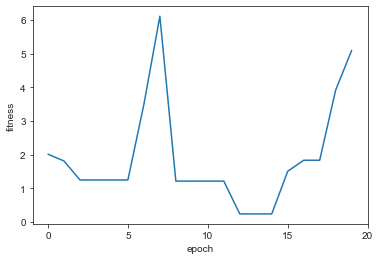

In [41]:
sns.set_style("ticks")
xtick = [0,5,10,15,20]
x = list(range(0,len(bestloss)))
fig = sns.lineplot(x,bestloss)
plt.xlabel("epoch")
plt.ylabel("fitness")
plt.xticks(xtick)
scatter_fig = fig.get_figure()
scatter_fig.savefig('./CS_Fitness', dpi = 400)

int